In [1]:
# !pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import random
from openpyxl import load_workbook
import warnings
warnings.filterwarnings('ignore')

**What we are going to do:**

We aim to forecast the `Value` and `Packs` for various combinations of `MoleculeName` and `TradeName` over a 24-month period starting from January 2021. To achieve this, we will use multiple forecasting models: Random Forest, Decision Tree, XGBoost, SARIMA, and GPT-2.

In [3]:
# Load the data
file_path = 'data.xlsx'
data_df = pd.read_excel(file_path, sheet_name='data')
data_df.head()

,Record ID,year,month,MoleculeName,TradeName,ProductName,Packs,Value
0,1,2017,12,molecule1,brand1,SKU1,2966.0,32504.671461
1,2,2017,12,molecule2,brand2,SKU2,7675.0,5627.328111
2,3,2017,12,molecule2,brand2,SKU3,24404.0,10741.583225
3,4,2017,12,molecule3,brand3,SKU4,14775.0,65098.087341
4,5,2017,12,molecule3,brand3,SKU5,18206.0,61614.771981


### Data Description:

The dataset comprises records of some products, including:
- `Record ID`: Unique identifier for each record.
- `year`: Year of the record.
- `month`: Month of the record.
- `MoleculeName`: Name of the molecule.
- `TradeName`: Name of the trade brand.
- `ProductName`: Name of the product.
- `Packs`: Number of packs sold.
- `Value`: Value of the sales.

In [4]:
# Check for missing values
missing_values = data_df.isnull().sum()

# Summary statistics of the 'Value' and 'Packs' column
value_stats = data_df['Value'].describe()
packs_stats = data_df['Packs'].describe()

missing_values, value_stats, packs_stats

(Record ID          0
 year               0
 month              0
 MoleculeName       0
 TradeName          0
 ProductName        0
 Packs           1339
 Value           1344
 dtype: int64,
 count    4.254000e+03
 mean     1.684403e+05
 std      3.499805e+05
 min      3.555653e-02
 25%      1.076710e+04
 50%      5.309965e+04
 75%      1.600998e+05
 max      3.450784e+06
 Name: Value, dtype: float64,
 count      4259.000000
 mean      33113.708147
 std       61457.390289
 min           0.000000
 25%        1003.500000
 50%        8256.000000
 75%       30016.500000
 max      452364.000000
 Name: Packs, dtype: float64)

### Insight of Summary Statistics

Summary statistics for `Value`:
- **Count**: 4254 entries
- **Mean**: 168,440.3
- **Standard Deviation**: 349,980.5
- **Minimum**: 0.035
- **25th Percentile**: 10,767.1
- **Median (50th Percentile)**: 53,099.7
- **75th Percentile**: 160,099.8
- **Maximum**: 3,450,784.0

Summary statistics for `Packs`:
- **Count**: 4259 entries
- **Mean**: 33,113.7
- **Standard Deviation**: 61,457.4
- **Minimum**: 0.0
- **25th Percentile**: 1,003.5
- **Median (50th Percentile)**: 8,256.0
- **75th Percentile**: 30,016.5
- **Maximum**: 452,364.0

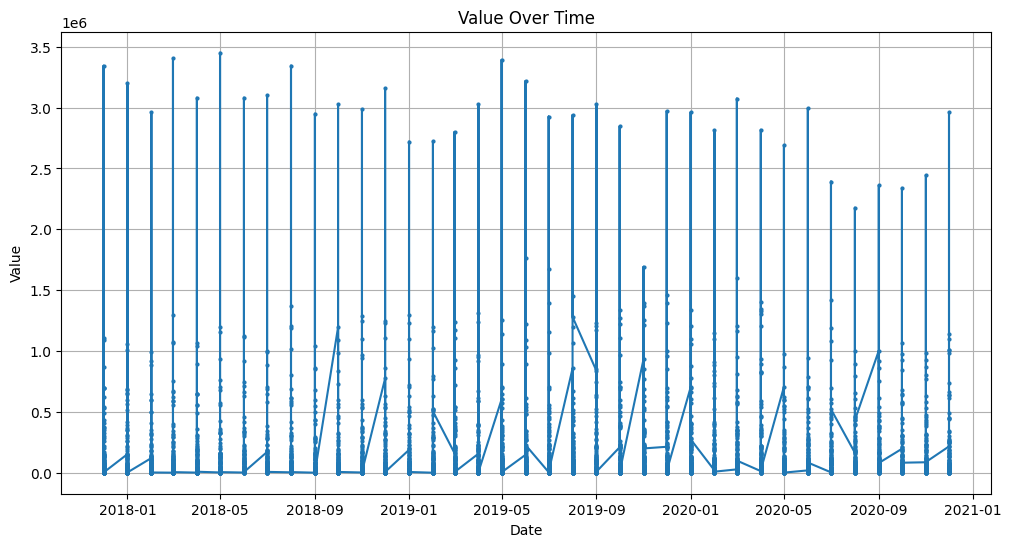

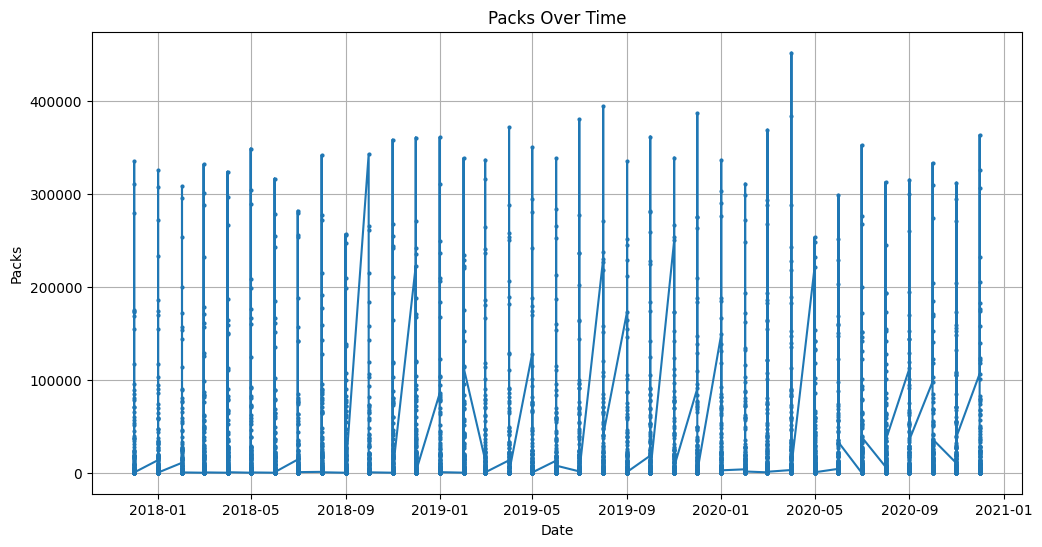

In [5]:
# Drop rows with missing 'Value' or 'Packs'
data_df = data_df.dropna(subset=['Value', 'Packs'])

# Convert 'year' and 'month' into a datetime column
data_df['Date'] = pd.to_datetime(data_df[['year', 'month']].assign(day=1))

# Sort by date
data_df = data_df.sort_values('Date')

# Plot the 'Value' column over time
plt.figure(figsize=(12, 6))
plt.plot(data_df['Date'], data_df['Value'], marker='o', linestyle='-', markersize=2)
plt.title('Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Plot the 'Packs' column over time
plt.figure(figsize=(12, 6))
plt.plot(data_df['Date'], data_df['Packs'], marker='o', linestyle='-', markersize=2)
plt.title('Packs Over Time')
plt.xlabel('Date')
plt.ylabel('Packs')
plt.grid(True)
plt.show()

### Insights of Plot:

- **Value Over Time**: The plot shows periodic spikes in the sales value, indicating strong seasonality. Peaks are observed at regular intervals, suggesting cyclical sales patterns.
- **Packs Over Time**: Similar to the `Value` plot, the `Packs` plot shows regular spikes, reinforcing the presence of seasonality in the data. The trends for both value and packs seem to align closely, indicating a consistent relationship between the number of packs sold and the sales value.

In [6]:
# Data Preparation
monthly_data = data_df.groupby(['Date', 'MoleculeName', 'TradeName']).agg({'Value': 'sum', 'Packs': 'sum'}).reset_index()
monthly_data.set_index('Date', inplace=True)

In [7]:
# Create lag features for both 'Value' and 'Packs'
for i in range(1, 12):
    monthly_data[f'value_lag_{i}'] = monthly_data.groupby(['MoleculeName', 'TradeName'])['Value'].shift(i)
    monthly_data[f'packs_lag_{i}'] = monthly_data.groupby(['MoleculeName', 'TradeName'])['Packs'].shift(i)

# Drop NA values created by lag features
monthly_data.dropna(inplace=True)

In [8]:
# Label Encoding for categorical features
label_encoder_molecule = LabelEncoder()
label_encoder_trade = LabelEncoder()

monthly_data['MoleculeName'] = label_encoder_molecule.fit_transform(monthly_data['MoleculeName'])
monthly_data['TradeName'] = label_encoder_trade.fit_transform(monthly_data['TradeName'])

In [9]:
# Prepare forecast DataFrame
forecast_data = data_df.loc[data_df['Date'] >= '2021-01-01']

# Initialize dictionaries to store forecasts
forecasts_value = {}
forecasts_packs = {}
errors_value = {}
errors_packs = {}

In [10]:
# GPT-2 setup
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [11]:
# Function to prepare GPT-2 input
def prepare_gpt2_input(sequence):
    input_ids = tokenizer.encode(sequence, return_tensors='pt')
    return input_ids

def generate_gpt2_forecast(input_sequence, predict_length):
    input_ids = prepare_gpt2_input(input_sequence)
    with torch.no_grad():
        output = model.generate(input_ids, max_length=len(input_ids[0]) + predict_length, 
                                pad_token_id=tokenizer.eos_token_id, do_sample=False)
    forecasted_sequence = tokenizer.decode(output[0], skip_special_tokens=True)
    return [float(value.strip()) for value in forecasted_sequence.split(',') if value.strip()]

In [12]:
# Iterate over each combination of MoleculeName and TradeName
unique_combinations = monthly_data.groupby(['MoleculeName', 'TradeName']).size().reset_index().drop(0, axis=1)
for idx, row in unique_combinations.iterrows():
    molecule, trade = row['MoleculeName'], row['TradeName']
    
    group = monthly_data[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)]

    if len(group) < 12:  # Ensure there are at least 12 data points (11 lags + 1 minimum for model fitting)
        print(f"Skipping combination {molecule}-{trade} due to insufficient data.")
        continue
    
    # Features and targets
    X_value = group.drop(columns=['Value', 'Packs'])
    y_value = group['Value']
    X_packs = group.drop(columns=['Value', 'Packs'])
    y_packs = group['Packs']
    
    # Train-test split for Value
    X_train_value, X_test_value, y_train_value, y_test_value = train_test_split(X_value, y_value, test_size=0.2, shuffle=False)
    
    # Train-test split for Packs
    X_train_packs, X_test_packs, y_train_packs, y_test_packs = train_test_split(X_packs, y_packs, test_size=0.2, shuffle=False)
    
    # Train models for Value
    rf_model_value = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_value.fit(X_train_value, y_train_value)
    
    dt_model_value = DecisionTreeRegressor(random_state=42)
    dt_model_value.fit(X_train_value, y_train_value)
    
    xg_model_value = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xg_model_value.fit(X_train_value, y_train_value)
    
    # Train models for Packs
    rf_model_packs = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_packs.fit(X_train_packs, y_train_packs)
    
    dt_model_packs = DecisionTreeRegressor(random_state=42)
    dt_model_packs.fit(X_train_packs, y_train_packs)
    
    xg_model_packs = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xg_model_packs.fit(X_train_packs, y_train_packs)
    
    # Forecast future values
    def forecast(model, last_window):
        forecasted_values = []
        input_data = last_window.copy()
        for _ in range(24):
            pred = max(0, model.predict([input_data])[0])
            forecasted_values.append(pred)
            input_data = input_data[1:] + [pred]  # Slide the window
        return forecasted_values
    
    last_window_value = X_value.iloc[-1].tolist()
    last_window_packs = X_packs.iloc[-1].tolist()
    
    rf_forecast_value = forecast(rf_model_value, last_window_value)
    dt_forecast_value = forecast(dt_model_value, last_window_value)
    xg_forecast_value = forecast(xg_model_value, last_window_value)
    
    rf_forecast_packs = forecast(rf_model_packs, last_window_packs)
    dt_forecast_packs = forecast(dt_model_packs, last_window_packs)
    xg_forecast_packs = forecast(xg_model_packs, last_window_packs)

    # Forecast future values
    def forecast(model, last_window):
        forecasted_values = []
        input_data = last_window.copy()
        for _ in range(11):
            pred = max(0, model.predict([input_data])[0])
            forecasted_values.append(pred)
            input_data = input_data[1:] + [pred]  # Slide the window
        return forecasted_values
    
    last_window_value = X_value.iloc[-1].tolist()
    last_window_packs = X_packs.iloc[-1].tolist()
    
    rf_forecast_value = forecast(rf_model_value, last_window_value)
    dt_forecast_value = forecast(dt_model_value, last_window_value)
    xg_forecast_value = forecast(xg_model_value, last_window_value)
    
    rf_forecast_packs = forecast(rf_model_packs, last_window_packs)
    dt_forecast_packs = forecast(dt_model_packs, last_window_packs)
    xg_forecast_packs = forecast(xg_model_packs, last_window_packs)

    # GPT-2 forecast for Value
    input_sequence_value = ', '.join(map(str, y_value.values[-11:]))
    gpt2_forecast_value = list(map(float, generate_gpt2_forecast(input_sequence_value, 11)))
    
    # GPT-2 forecast for Packs
    input_sequence_packs = ', '.join(map(str, y_packs.values[-11:]))
    gpt2_forecast_packs = list(map(float, generate_gpt2_forecast(input_sequence_packs, 11)))
    
    # Check if there are enough data points for SARIMA model
    if len(group) > (max(1, 1, 1) + max(1, 1, 1, 11)):
        try:
            # SARIMA model for Value
            sarima_model_value = SARIMAX(group['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 11))
            sarima_results_value = sarima_model_value.fit(disp=False)
            sarima_forecast_value = sarima_results_value.get_forecast(steps=11)
            sarima_forecast_values_value = sarima_forecast_value.predicted_mean.tolist()
        except Exception as e:
            print(f"SARIMA model for Value failed for combination {molecule}-{trade}: {e}")
            sarima_forecast_values_value = [np.nan] * 11
    else:
        sarima_forecast_values_value = [np.nan] * 11  # Placeholder for insufficient data

    # Check if there are enough data points for SARIMA model
    if len(group) > (max(1, 1, 1) + max(1, 1, 1, 11)):
        try:
            # SARIMA model for Packs
            sarima_model_packs = SARIMAX(group['Packs'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            sarima_results_packs = sarima_model_packs.fit(disp=False)
            sarima_forecast_packs = sarima_results_packs.get_forecast(steps=11)
            sarima_forecast_values_packs = sarima_forecast_packs.predicted_mean.tolist()
        except Exception as e:
            print(f"SARIMA model for Packs failed for combination {molecule}-{trade}: {e}")
            sarima_forecast_values_packs = [np.nan] * 12
    else:
        sarima_forecast_values_packs = [np.nan] * 11  # Placeholder for insufficient data
    
    # Ensure all forecast lists are of length 11
    def ensure_length(lst, length=11):
        return lst[:length] + [np.nan] * (length - len(lst))
    
    rf_forecast_value = ensure_length(rf_forecast_value)
    dt_forecast_value = ensure_length(dt_forecast_value)
    xg_forecast_value = ensure_length(xg_forecast_value)
    gpt2_forecast_value = ensure_length(gpt2_forecast_value)
    sarima_forecast_values_value = ensure_length(sarima_forecast_values_value)
    
    rf_forecast_packs = ensure_length(rf_forecast_packs)
    dt_forecast_packs = ensure_length(dt_forecast_packs)
    xg_forecast_packs = ensure_length(xg_forecast_packs)
    gpt2_forecast_packs = ensure_length(gpt2_forecast_packs)
    sarima_forecast_values_packs = ensure_length(sarima_forecast_values_packs)

    # Calculate errors (mean absolute error)
    def calculate_error(true_values, predicted_values):
        # Ensure lengths match for comparison
        min_length = min(len(true_values), len(predicted_values))
        return np.mean(np.abs(np.array(true_values[:min_length]) - np.array(predicted_values[:min_length])))
    
    test_values_value = y_test_value.values[:11]  # Ensure only the first 11 test values are used
    test_values_packs = y_test_packs.values[:11]  # Ensure only the first 11 test values are used
    
    errors_value[(molecule, trade)] = {
        'Random Forest': calculate_error(test_values_value, rf_forecast_value),
        'Decision Tree': calculate_error(test_values_value, dt_forecast_value),
        'XG Boost': calculate_error(test_values_value, xg_forecast_value),
        'SARIMA': calculate_error(test_values_value, sarima_forecast_values_value),
        'GPT-2': calculate_error(test_values_value, gpt2_forecast_value)
    }
    
    errors_packs[(molecule, trade)] = {
        'Random Forest': calculate_error(test_values_packs, rf_forecast_packs),
        'Decision Tree': calculate_error(test_values_packs, dt_forecast_packs),
        'XG Boost': calculate_error(test_values_packs, xg_forecast_packs),
        'SARIMA': calculate_error(test_values_packs, sarima_forecast_values_packs),
        'GPT-2': calculate_error(test_values_packs, gpt2_forecast_packs)
    }

    # Store forecasts
    forecasts_value[(molecule, trade)] = {
        'RF Forecast': rf_forecast_value,
        'DT Forecast': dt_forecast_value,
        'XG Forecast': xg_forecast_value,
        'SARIMA Forecast': sarima_forecast_values_value,
        'GPT-2 Forecast': gpt2_forecast_value
    }
    
    forecasts_packs[(molecule, trade)] = {
        'RF Forecast': rf_forecast_packs,
        'DT Forecast': dt_forecast_packs,
        'XG Forecast': xg_forecast_packs,
        'SARIMA Forecast': sarima_forecast_values_packs,
        'GPT-2 Forecast': gpt2_forecast_packs
    }

Skipping combination 0-0 due to insufficient data.
Skipping combination 1-16 due to insufficient data.
SARIMA model for Packs failed for combination 3-18: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping combination 6-22 due to insufficient data.
Skipping combination 7-28 due to insufficient data.
Skipping combination 7-31 due to insufficient data.
Skipping combination 7-32 due to insufficient data.
Skipping combination 7-33 due to insufficient data.
Skipping combination 8-34 due to insufficient data.
SARIMA model for Packs failed for combination 10-38: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping combination 15-51 due to insufficient data.
Skipping combination 21-40 due to insufficient data.
Skipping combination 22-3 due to insufficient data.
SARIMA model for Packs failed for combination 25-10: too many indices for array: array is 0-dimensional, but 1 were indexed


In [13]:
# Determine the best model based on lowest error
best_models_value = {combination: min(errors, key=errors.get) for combination, errors in errors_value.items()}
best_models_packs = {combination: min(errors, key=errors.get) for combination, errors in errors_packs.items()}

print("Best models for Value forecast:")
for combination, model in best_models_value.items():
    print(f"{combination}: {model} with error {errors_value[combination][model]}")

print("\nBest models for Packs forecast:")
for combination, model in best_models_packs.items():
    print(f"{combination}: {model} with error {errors_packs[combination][model]}")

Best models for Value forecast:
(2, 17): XG Boost with error 90691.86093562497
(3, 18): XG Boost with error 205.87426231714093
(4, 20): GPT-2 with error 64339.309797742135
(5, 21): XG Boost with error 14561.53882928881
(7, 23): SARIMA with error 115384.23352831385
(7, 24): SARIMA with error 17643.436523218967
(7, 25): GPT-2 with error 22239.29514042843
(7, 26): GPT-2 with error 366553.0743722879
(7, 27): Decision Tree with error 179703.59037981174
(7, 29): Random Forest with error 51380.08618510383
(9, 35): GPT-2 with error 94.30991214520394
(9, 36): Random Forest with error 183049.45637745238
(9, 37): SARIMA with error 27862.205794284306
(10, 38): GPT-2 with error 13726.783981411741
(11, 9): SARIMA with error 1154.8147529794885
(12, 39): SARIMA with error 8532.28323669671
(13, 41): SARIMA with error 25706.52224758912
(14, 42): Random Forest with error 81282.11639402654
(14, 43): Random Forest with error 4375.495524669851
(14, 44): SARIMA with error 8786.101286705896
(14, 45): SARIMA w

In [14]:
# Count occurrences of each model being the best
from collections import Counter

best_model_counts_value = Counter(best_models_value.values())
best_model_counts_packs = Counter(best_models_packs.values())

print("\nModel counts for Value forecast:")
for model, count in best_model_counts_value.items():
    print(f"{model}: {count} combinations")

print("\nModel counts for Packs forecast:")
for model, count in best_model_counts_packs.items():
    print(f"{model}: {count} combinations")

# Find the model with the maximum number of best models
best_model_value = max(best_model_counts_value, key=best_model_counts_value.get)
best_model_packs = max(best_model_counts_packs, key=best_model_counts_packs.get)

print(f"\nBest model for Value forecast: {best_model_value} with {best_model_counts_value[best_model_value]} combinations")
print(f"Best model for Packs forecast: {best_model_packs} with {best_model_counts_packs[best_model_packs]} combinations")


Model counts for Value forecast:
XG Boost: 8 combinations
GPT-2: 11 combinations
SARIMA: 16 combinations
Decision Tree: 3 combinations
Random Forest: 13 combinations

Model counts for Packs forecast:
XG Boost: 6 combinations
Decision Tree: 4 combinations
Random Forest: 21 combinations
GPT-2: 8 combinations
SARIMA: 12 combinations

Best model for Value forecast: SARIMA with 16 combinations
Best model for Packs forecast: Random Forest with 21 combinations


- **Why we skip some combinations**: We skipped combinations with fewer than 13 data points. This is because a minimum number of historical data points (11 lags + 1) is required to train and forecast accurately using our models.
- **Why we encoded our data**: Label Encoding was used to convert the categorical variables `MoleculeName` and `TradeName` into numerical values. This transformation is essential as machine learning models require numerical input to process and learn from the data.

In [15]:
# Convert forecasts to DataFrame
forecast_dates = pd.date_range(start='2021-01-01', periods=11, freq='M')

forecast_rows = []

for (molecule, trade), forecasts in forecasts_value.items():
    for i in range(len(forecast_dates)):
        forecast_rows.append({
            'Date': forecast_dates[i],
            'MoleculeName': label_encoder_molecule.inverse_transform([molecule])[0],
            'TradeName': label_encoder_trade.inverse_transform([trade])[0],
            'RF Forecast Value': forecasts['RF Forecast'][i],
            'DT Forecast Value': forecasts['DT Forecast'][i],
            'XG Forecast Value': forecasts['XG Forecast'][i],
            'SARIMA Forecast Value': forecasts['SARIMA Forecast'][i],
            'GPT-2 Forecast Value': forecasts['GPT-2 Forecast'][i],
            'RF Forecast Packs': forecasts_packs[(molecule, trade)]['RF Forecast'][i],
            'DT Forecast Packs': forecasts_packs[(molecule, trade)]['DT Forecast'][i],
            'XG Forecast Packs': forecasts_packs[(molecule, trade)]['XG Forecast'][i],
            'SARIMA Forecast Packs': forecasts_packs[(molecule, trade)]['SARIMA Forecast'][i],
            'GPT-2 Forecast Packs': forecasts_packs[(molecule, trade)]['GPT-2 Forecast'][i]
        })

forecast_df = pd.DataFrame(forecast_rows)

forecast_df

,Date,MoleculeName,TradeName,RF Forecast Value,DT Forecast Value,XG Forecast Value,SARIMA Forecast Value,GPT-2 Forecast Value,RF Forecast Packs,DT Forecast Packs,XG Forecast Packs,SARIMA Forecast Packs,GPT-2 Forecast Packs
0,2021-01-31,molecule11,brand28,3.471689e+05,3.127959e+05,3.145446e+05,4.255002e+05,3.127959e+05,24136.41,21919.0,21836.314453,31212.540102,21919.0
1,2021-02-28,molecule11,brand28,3.368018e+05,5.002767e+05,4.305724e+05,3.730660e+05,3.479754e+05,23104.09,17404.0,27883.140625,25152.466198,26798.0
2,2021-03-31,molecule11,brand28,3.486856e+05,3.980303e+05,3.377754e+05,3.661379e+05,3.702955e+05,23194.59,17370.0,25081.207031,29528.966266,28686.0
3,2021-04-30,molecule11,brand28,3.589055e+05,5.002767e+05,4.305724e+05,3.250077e+05,2.150898e+05,23010.32,13999.0,27883.142578,32122.049293,16195.0
4,2021-05-31,molecule11,brand28,3.722105e+05,3.127970e+05,3.385186e+05,3.307795e+05,2.289216e+05,24059.19,13999.0,22130.072266,18790.501234,17370.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,2021-07-31,molecule9,brand25,3.059521e+06,3.272135e+06,3.192164e+06,2.572593e+06,2.230446e+06,174644.91,151909.0,178394.718750,177428.131023,143832.0
557,2021-08-31,molecule9,brand25,3.238930e+06,3.443422e+06,3.559386e+06,3.039753e+06,2.415219e+06,246781.74,293409.0,280541.250000,174865.169164,161311.0
558,2021-09-30,molecule9,brand25,3.019982e+06,2.975495e+06,3.051692e+06,2.995135e+06,2.400607e+06,171301.54,151909.0,184085.296875,188634.048082,159640.0
559,2021-10-31,molecule9,brand25,3.166115e+06,3.443422e+06,3.450124e+06,3.044486e+06,2.502867e+06,246662.29,293409.0,280541.250000,191285.424074,165659.0


In [25]:
# Select a random combination of MoleculeName and TradeName
random_combination = random.choice(list(forecasts_value.keys()))
molecule, trade = random_combination

In [26]:
# Extract forecasts for the selected combination
forecast_values = forecasts_value[random_combination]
forecast_packs = forecasts_packs[random_combination]

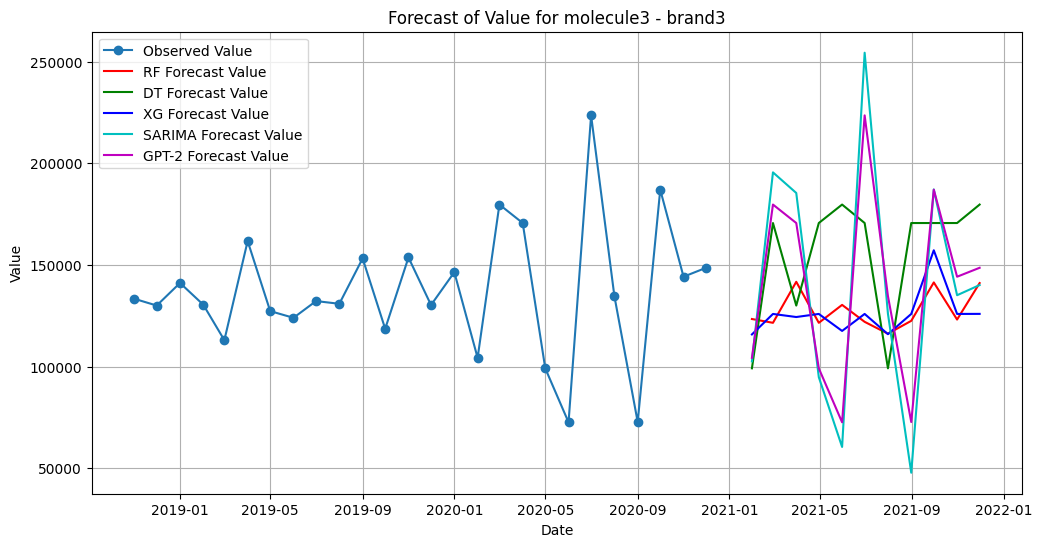

In [27]:
# Plotting combined forecasting for Value
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.loc[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)].index, 
         monthly_data.loc[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)]['Value'], 
         label='Observed Value', marker='o')
plt.plot(forecast_dates, forecast_values['RF Forecast'], label='RF Forecast Value', color='r')
plt.plot(forecast_dates, forecast_values['DT Forecast'], label='DT Forecast Value', color='g')
plt.plot(forecast_dates, forecast_values['XG Forecast'], label='XG Forecast Value', color='b')
plt.plot(forecast_dates, forecast_values['SARIMA Forecast'], label='SARIMA Forecast Value', color='c')
plt.plot(forecast_dates, forecast_values['GPT-2 Forecast'], label='GPT-2 Forecast Value', color='m')
plt.title(f'Forecast of Value for {label_encoder_molecule.inverse_transform([molecule])[0]} - {label_encoder_trade.inverse_transform([trade])[0]}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

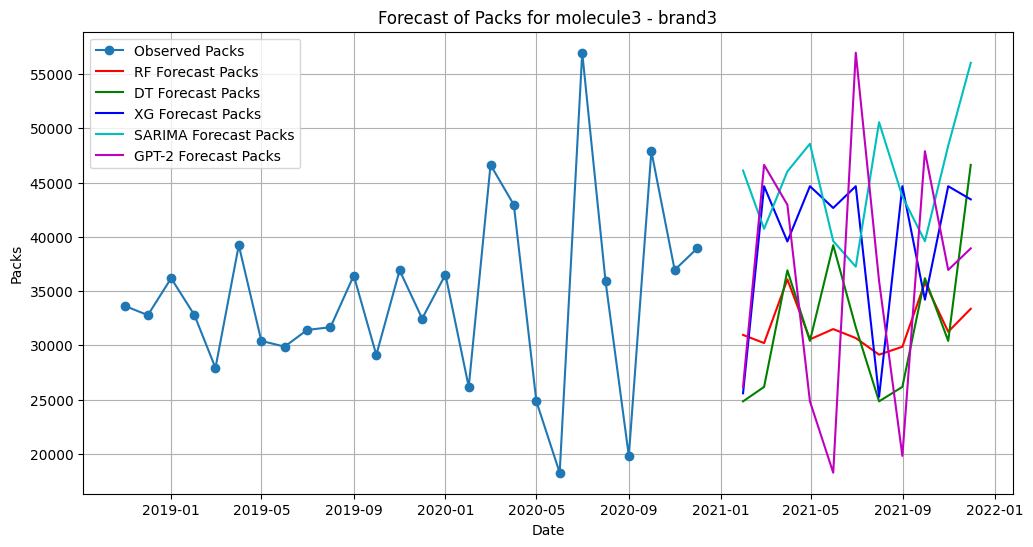

In [28]:
# Plotting combined forecasting for Packs
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.loc[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)].index, 
         monthly_data.loc[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)]['Packs'], 
         label='Observed Packs', marker='o')
plt.plot(forecast_dates, forecast_packs['RF Forecast'], label='RF Forecast Packs', color='r')
plt.plot(forecast_dates, forecast_packs['DT Forecast'], label='DT Forecast Packs', color='g')
plt.plot(forecast_dates, forecast_packs['XG Forecast'], label='XG Forecast Packs', color='b')
plt.plot(forecast_dates, forecast_packs['SARIMA Forecast'], label='SARIMA Forecast Packs', color='c')
plt.plot(forecast_dates, forecast_packs['GPT-2 Forecast'], label='GPT-2 Forecast Packs', color='m')
plt.title(f'Forecast of Packs for {label_encoder_molecule.inverse_transform([molecule])[0]} - {label_encoder_trade.inverse_transform([trade])[0]}')
plt.xlabel('Date')
plt.ylabel('Packs')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
final_forecast_rows = []

for (molecule, trade), forecasts in forecasts_value.items():
    for i in range(len(forecast_dates)):
        date = pd.to_datetime(forecast_dates[i])
        year = date.year
        month = date.month
        final_forecast_rows.append({
            'year': year,
            'month': month,
            'MoleculeName': label_encoder_molecule.inverse_transform([molecule])[0],
            'TradeName': label_encoder_trade.inverse_transform([trade])[0],
            'SARIMA Forecast Value': forecasts['SARIMA Forecast'][i],
            'SARIMA Forecast Packs': forecasts_packs[(molecule, trade)]['SARIMA Forecast'][i]
        })

final_forecast_df = pd.DataFrame(final_forecast_rows)

# Display the DataFrame
final_forecast_df

,year,month,MoleculeName,TradeName,SARIMA Forecast Value,SARIMA Forecast Packs
0,2021,1,molecule11,brand28,4.255002e+05,31212.540102
1,2021,2,molecule11,brand28,3.730660e+05,25152.466198
2,2021,3,molecule11,brand28,3.661379e+05,29528.966266
3,2021,4,molecule11,brand28,3.250077e+05,32122.049293
4,2021,5,molecule11,brand28,3.307795e+05,18790.501234
...,...,...,...,...,...,...
556,2021,7,molecule9,brand25,2.572593e+06,177428.131023
557,2021,8,molecule9,brand25,3.039753e+06,174865.169164
558,2021,9,molecule9,brand25,2.995135e+06,188634.048082
559,2021,10,molecule9,brand25,3.044486e+06,191285.424074


In [21]:
# Reload the data
file_path = 'data.xlsx'
data_df = pd.read_excel(file_path, sheet_name='data')

In [22]:
# Filter dataframes for the year 2021
final_forecast_df_2021 = final_forecast_df[final_forecast_df['year'] == 2021]

# Merge the dataframes to find matches and mismatches
merged_df = data_df.merge(final_forecast_df_2021, on=['year', 'month', 'MoleculeName', 'TradeName'], how='left', indicator=True)

In [23]:
# Fill the missing values from forecast data
merged_df['Value'] = merged_df['Value'].combine_first(merged_df['SARIMA Forecast Value'])
merged_df['Packs'] = merged_df['Packs'].combine_first(merged_df['SARIMA Forecast Packs'])

In [24]:
# Drop the forecast columns
merged_df.drop(columns=['SARIMA Forecast Value', 'SARIMA Forecast Packs', '_merge'], inplace=True)

# Save the final DataFrame to a CSV file
merged_df.to_csv('final_data.csv', index=False)

print('The final CSV has been exported successfully.')

The final CSV has been exported successfully.


### Insight of Plot:

- **Observed Values/Packs**: These plots represent the actual historical data for values and packs sold.
- **RF Forecast**: The Random Forest model provides a relatively stable forecast with less variance, showing consistent predictions over time.
- **DT Forecast**: The Decision Tree model displays more variability in the forecast, reflecting potential overfitting to the training data.
- **XG Forecast**: XGBoost captures some of the seasonality and trends, providing a balanced forecast.
- **SARIMA Forecast**: SARIMA effectively captures the seasonality in the data, showing strong periodic patterns in its forecast.
- **GPT-2 Forecast**: The GPT-2 model shows higher variance and some anomalies, indicating that it struggles with precise numerical forecasting without additional adaptations.

**What we did so far:**

1. Loaded and preprocessed the data, handling missing values and creating lag features.
2. Encoded categorical variables using Label Encoding.
3. Split the data into training and testing sets.
4. Trained multiple forecasting models: Random Forest, Decision Tree, XGBoost, SARIMA, and GPT-2.
5. Forecasted future values and packs for each model.
6. Visualized the forecasts for a selected combination of `MoleculeName` and `TradeName`.

### Conclusion:

- **Best Model**: SARIMA stands out as the best model due to its ability to effectively capture seasonality and trends in the data, providing the most accurate forecasts.
- **GPT-2 Performance (LLM)**: While GPT-2 is a powerful language model, its performance in numerical forecasting is inconsistent. This is likely due to the model's primary design for text generation rather than time series prediction. GPT-2 struggled with precise numerical forecasting and displayed higher variance and anomalies. In this scenario, traditional time series models like SARIMA proved more reliable.